In [1]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
from scipy.stats import ttest_ind, ttest_rel, chisquare, ks_2samp

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

In [5]:
from scipy import stats

# Normal distribution

In [6]:
def get_samp_cont(seed, X_mean, size=30):
    np.random.seed(seed)
    X = np.random.normal(X_mean, 1, size)
    Y = np.random.normal(0, 1, size)
    return X, Y

### Abosolute diff

In [7]:
def get_diff(val1, val2):
    return np.array(val1) - np.array(val2)

### Relative diff

In [8]:
def rel_error(val1, val2):
    return (np.array(val1) - np.array(val2)) / np.array(val2)

In [9]:
def run_test(seed,sample_size, p_dict, sample_func, x_mean=0,bins=None):
    #Get samples
    X, Y = sample_func(seed, x_mean, sample_size)
    
    #Ttest
    p_dict["ttest"].append(ttest_ind(X, Y)[1])
    
    #Exact test
    SGM = significance_of_mean_cuda(bins, dtype_v=np.uint16,dtype_A=np.float64)
    SGM.run(X.reshape(1,-1),Y.reshape(1,-1))
    p_dict["exact"].append(SGM.p_values[0])
        
    return p_dict

## Experiment func: $n_{bins}=[10,12,...,40]$, Number of $n_{samples}=70$, Set-size $|A|=|B|=100$

In [10]:
def test_for_dist(x_mean):
    Bin = list()
    Diff = list()
    Diff_rel = list()
    for nbins in range(10,42,2):
        p_val = dict()
        p_val["ttest"], p_val["exact"] = list(), list()
        for s in range(70):
            p_val = run_test(s, 100, p_val, get_samp_cont, x_mean, bins=nbins)
        #Divide ttest with 2 since sklearn calculate 2-side p-value.
        dif = get_diff(p_val["exact"], np.asarray(p_val["ttest"]) / 2 )
        dif_rel = rel_error(p_val["exact"], np.asarray(p_val["ttest"]) / 2 )
        Diff.append(dif)
        Bin.append(nbins)
        Diff_rel.append(dif_rel)
    return Diff, Diff_rel, Bin
    

# Run experiment with $\mu=[0,0.2,\ldots,1.8,2]$ and save.

In [11]:
step_s = 0.2
all_experiment_dif, all_experiment_rel_dif, all_experiment_bins = list(), list(), list()
for i, m in enumerate(np.arange(0, 2.2, step_s)):
    Diff,Diff_rel, Bin = test_for_dist(m)
    all_experiment_dif.append(Diff)
    all_experiment_rel_dif.append(Diff_rel)
    all_experiment_bins.append(Bin)


In [15]:
def boxPlot(error, Bin, error_type="abs",path=None):
    my_dict = dict()
    for d, b in zip(error, Bin):
        my_dict[str(b)] = d
    
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    
    if error_type=="abs":
        plt.ylabel(r"$p_{exact\ test}-p_{t-test}$",fontsize=18)
    elif error_type=="rel":
        plt.ylabel(r"$\frac{p_{exact\ test}-p_{t-test}}{p_{t-test}}$",fontsize=20)
        
    plt.xlabel("Bin size",fontsize=15)
    
    
    plt.title(r"$A=N(0,1),\ B=N("+str(np.round(i*0.2,2))+",1)$",fontsize=22)
    
    if path:
        fig.savefig(path+ str(i)+".jpg", bbox_inches='tight')
        
    

In [28]:
def errorPlot(error, Bin, error_type="abs", path=None):
    y = np.asarray(error).mean(axis=1)
    y_err = np.asarray(error).std(axis=1)
    
    
    if error_type=="abs":
        plt.ylabel(r"$p_{exact\ test}-p_{t-test}$",fontsize=18)
    elif error_type=="rel":
        plt.ylabel(r"$\frac{p_{exact\ test}-p_{t-test}}{p_{t-test}}$",fontsize=25)

    plt.figure()
    plt.errorbar(Bin,y,y_err)
    
    plt.xlabel("Bin size",fontsize=15)
    plt.ylabel(r"$p_{exact\ test}-p_{t-test}$",fontsize=18)
    plt.title(r"$A=N(0,1),\ B=N("+str(np.round(i*0.2,2))+",1)$",fontsize=20)
    if path:
        plt.savefig(path+ str(i)+".jpg", bbox_inches='tight')

# Boxplots: Absolute error

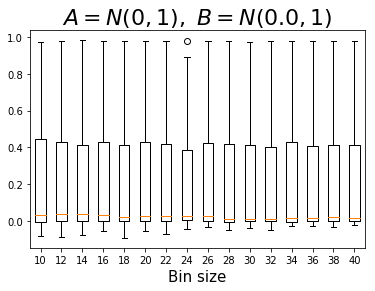

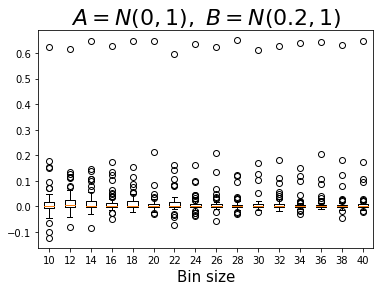

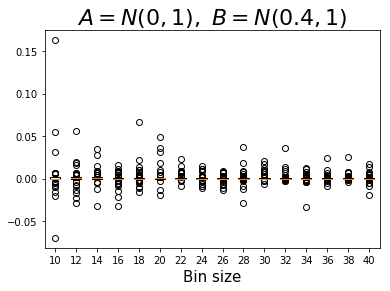

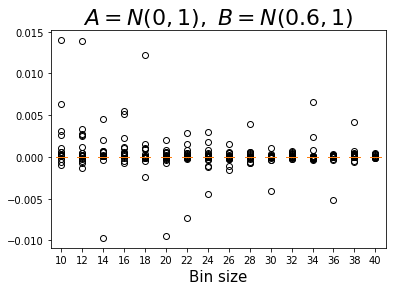

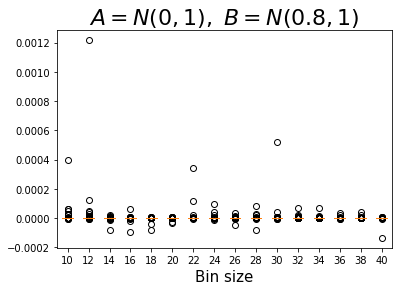

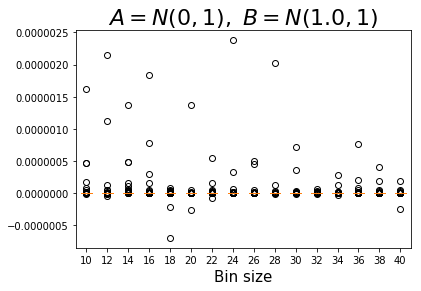

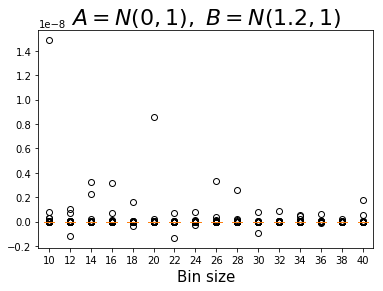

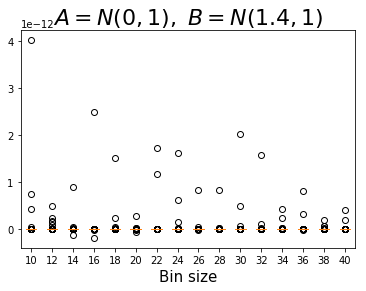

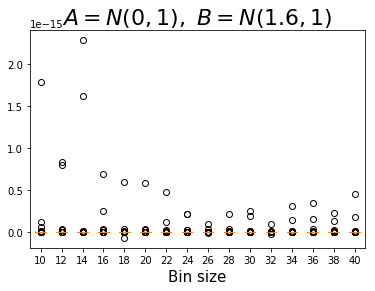

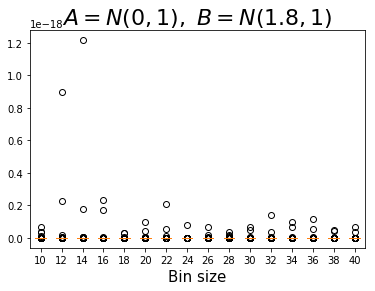

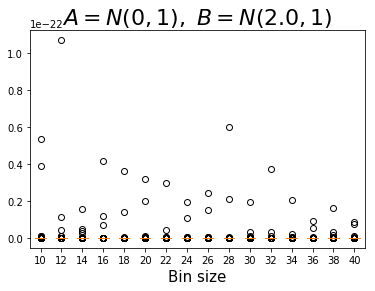

In [17]:
for i, (error, Bin) in enumerate(zip(all_experiment_dif, all_experiment_bins)):
    boxPlot(error, Bin,"figures/calibration/abs_box/box_abs_")
    

# Error-bar plot: Abolsute error

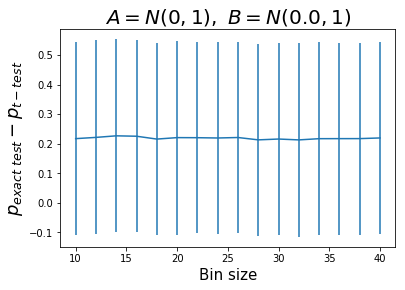

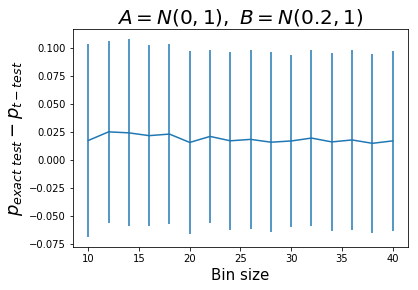

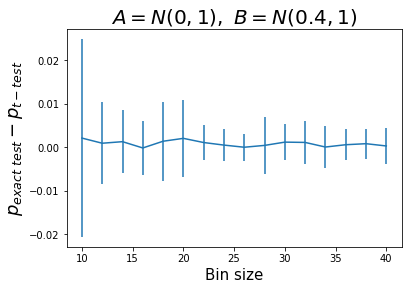

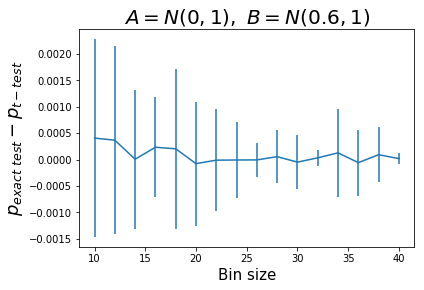

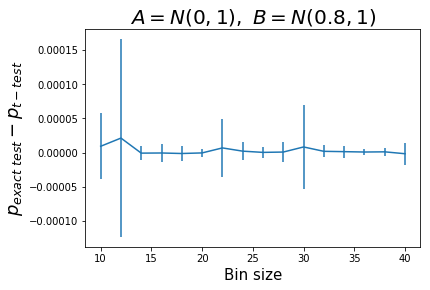

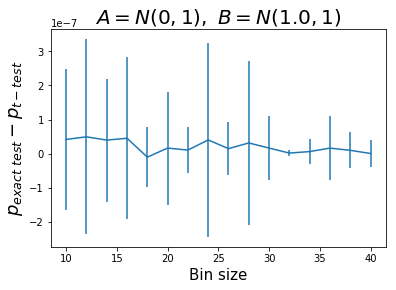

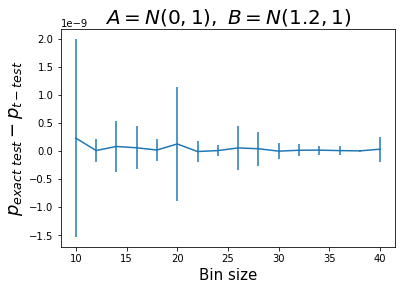

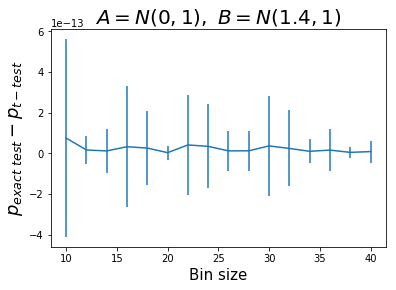

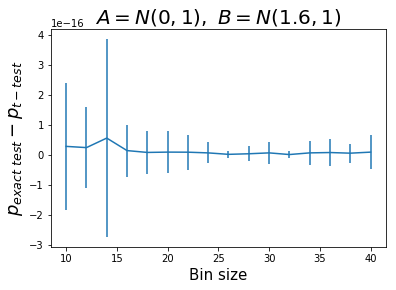

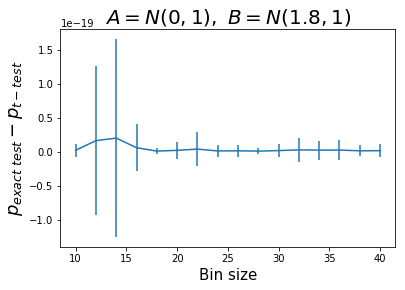

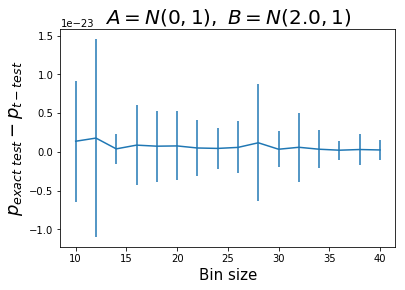

In [25]:
for i, (error, Bin) in enumerate(zip(all_experiment_dif, all_experiment_bins)):
    errorPlot(error, Bin, "figures/calibration/abs_error/error_abs_")

# Boxplot: Relative error

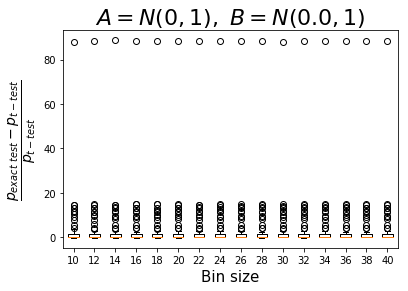

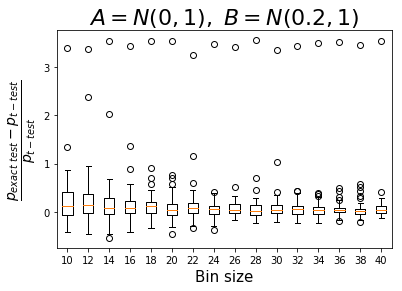

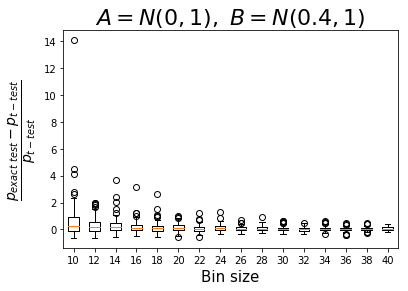

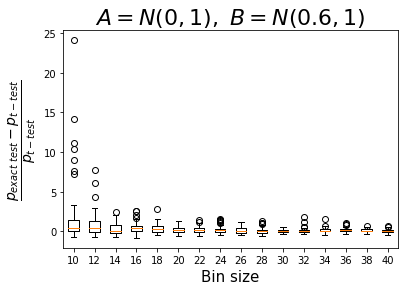

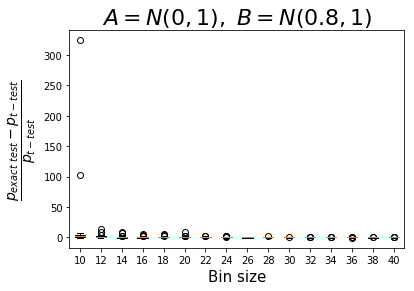

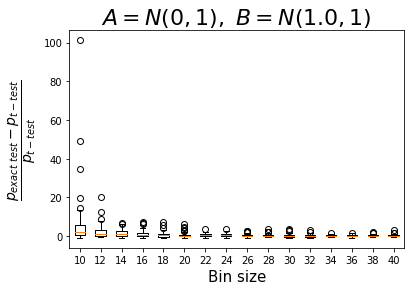

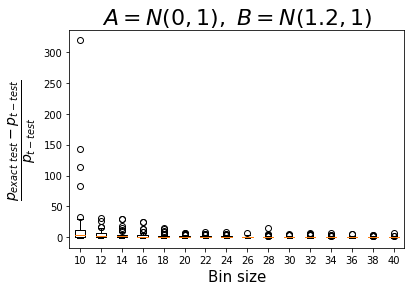

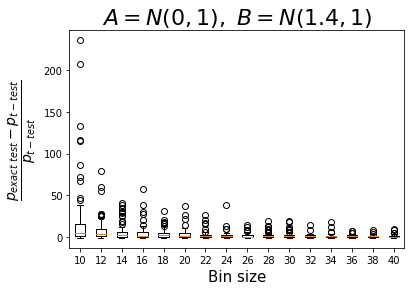

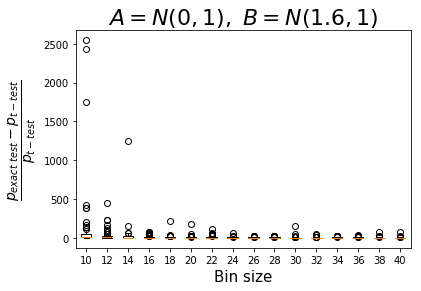

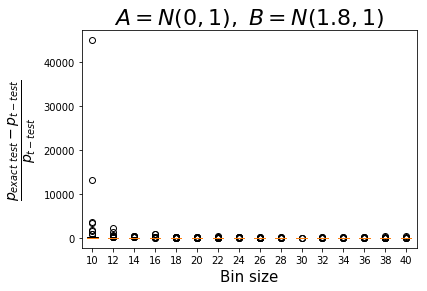

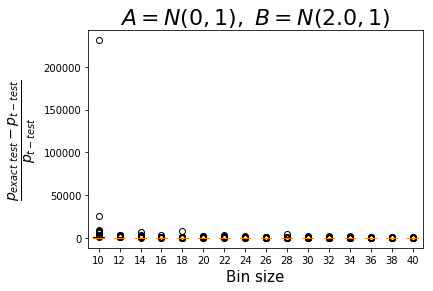

In [19]:
for i, (error, Bin) in enumerate(zip(all_experiment_rel_dif, all_experiment_bins)):
    boxPlot(error, Bin, "rel", "figures/calibration/rel_box/rel_box_")

# Error-bar plot: Relative error

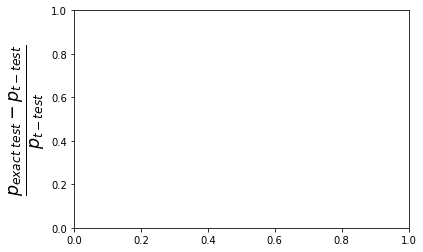

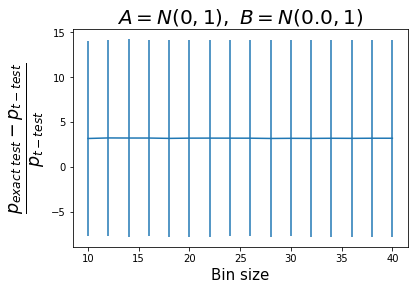

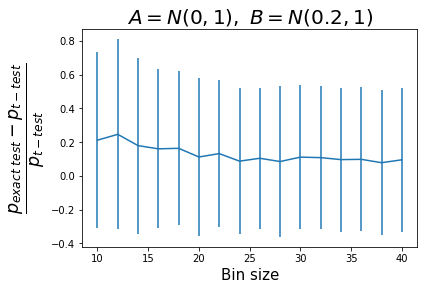

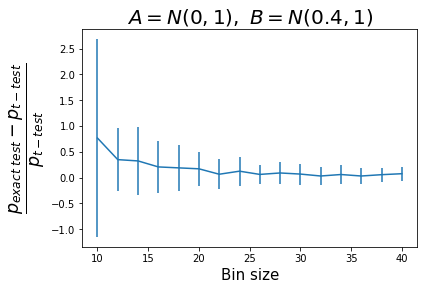

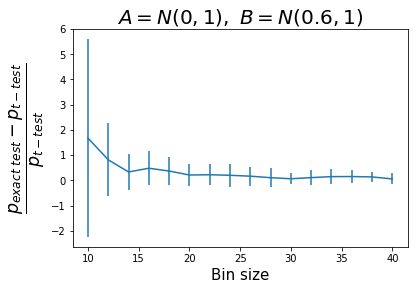

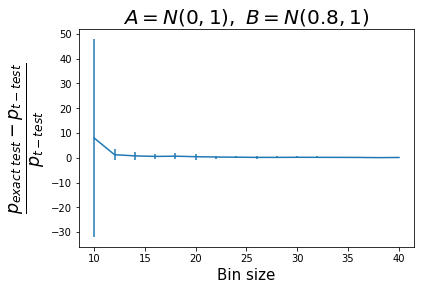

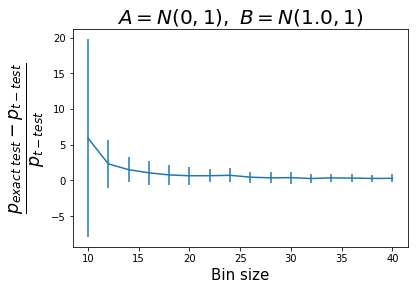

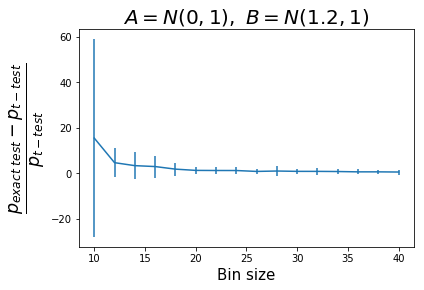

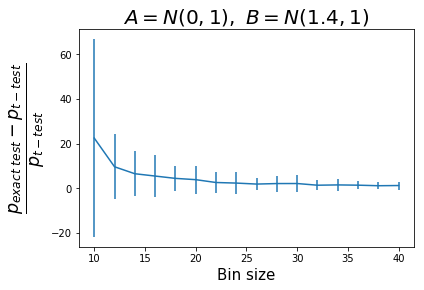

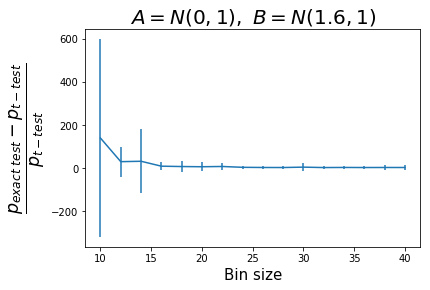

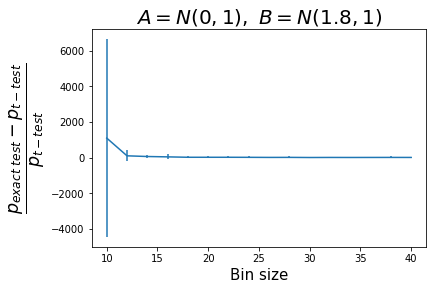

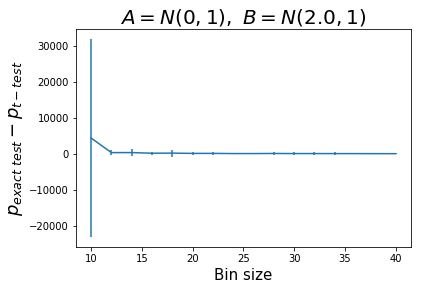

In [29]:
for i, (error, Bin) in enumerate(zip(all_experiment_rel_dif, all_experiment_bins)):
    errorPlot(error, Bin, "rel","figures/calibration/rel_error/rel_error_")